# Fonctions

In [1]:
# Libraries

import gzip
import requests
import pandas as pd
import shutil
import os
import zipfile
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pyl
import matplotlib as mpl
import cv2
from datetime import datetime
from datetime import timedelta

In [81]:
# ARCHIVE EXTENSIONS
ZIP_EXTENSION = ".zip"
TAR_EXTENSION = ".tar"
TAR_GZ_EXTENSION = ".tar.gz"
TGZ_EXTENSION = ".tgz"
GZ_EXTENSION = ".gz"

EMPTY_URL_ERROR = "ERROR: URL should not be empty."
FILENAME_ERROR = "ERROR: Filename should not be empty."
UNKNOWN_FORMAT = "ERROR: Unknown file format. Can't extract."


def extract_file(target_path, filename):
	"""Extract file based on file extension
	target_path: string, location where data will be extracted
	filename: string, name of the file along with extension
	"""
	if filename == "" or filename is None:
		raise Exception(FILENAME_ERROR)

	file_location = get_file_location(target_path, filename)

	if filename.endswith(ZIP_EXTENSION):
		print("Extracting zip file...")
		zipf = zipfile.ZipFile(file_location, 'r')
		zipf.extractall(target_path)
		zipf.close()
	elif filename.endswith(TAR_EXTENSION) or \
		 filename.endswith(TAR_GZ_EXTENSION) or \
		 filename.endswith(TGZ_EXTENSION):
		print("Extracting tar file")
		tarf = tarfile.open(file_location, 'r')
		tarf.extractall(target_path)
		tarf.close()
	elif filename.endswith(GZ_EXTENSION):
		with gzip.open(file_location, 'r') as f_in, open(file_location[:-2] + 'dat', 'wb') as f_out:
			shutil.copyfileobj(f_in, f_out)
	else:
		print(UNKNOWN_FORMAT)

def silent_download_dataset(url, target_path="temp_data/", keep_download=True, overwrite_download=False):
    """Downloads dataset from a url.
    url: string, a dataset path
    target_path: string, path where data will be downloaded
    keep_download: boolean, keeps the original file after extraction
    overwrite_download: boolean, stops download if dataset already exists
    """
    if url == "" or url is None:
        raise Exception(EMPTY_URL_ERROR)

    filename = get_filename(url)
    file_location = get_file_location(target_path, filename)
    

    os.makedirs(target_path, exist_ok=True)

    if os.path.exists(file_location) and not overwrite_download:
        extract_file(target_path, filename)
        return


    # Download
    with open(file_location, 'wb') as f:
        with requests.get(url, allow_redirects=True, stream=True) as resp:
            for chunk in resp.iter_content(chunk_size = 512):  #chunk_size in bytes
                if chunk:
                    f.write(chunk)

    extract_file(target_path, filename)

    if not keep_download:
        os.remove(file_location)


def get_filename(url):
	"""Extract filename from file url"""
	filename = os.path.basename(url)
	return filename

def get_file_location(target_path, filename):
	""" Concatenate download directory and filename"""
	return target_path + filename

def read_datfile(filepath, image=False):

    ##  Fonction qui permet d'extraire les données des fichiers dat JRC en array. 

    # str filepath: emplacement du fichier
    # boolean image: active ou non l'affichage de l'array sous forme d'image

    ##

  X = np.loadtxt(filepath, dtype = str, skiprows=32)

  d1 = len(X)
  d2 = len(X[0].split(sep = ','))

  Y = np.zeros((d1,d2))

  for i in range (d1):
    Y[i,:] = X[i].split(sep = ',')

  Z = Y.astype('float')
  Z =  np.flipud(Z)

  if image:
    plt.imshow(Z)
    plt.colorbar()

  return(Z)


def silent_read_url(url, image = False):

  silent_download_dataset(url, target_path="temp_data/")
  filepath = "temp_data/" + url[82:-3]
  Z = read_datfile(filepath, image)

  return (Z)

def build_url(data, forecast, date):

  #renvoie l'url correspondant en fonction des données et de la date demandées  
  #data: int, 0 pour PLL error et 1 pour lost-of-lock probability
  #forecast: int, 0 pour nowcasting et 1 pour forecast
  #year, string de longueur 4
  #month, doy, day, hour, min, string de longueur 2
  year = date.strftime('%Y')
  month = date.strftime('%m')
  day = date.strftime('%d')
  doy = date.strftime('%j')
  hour = date.strftime('%H')
  min = date.strftime('%M')

  url_root = 'https://ionospheric-prediction.jrc.ec.europa.eu/products/Ionosphere/RPF3/'

  url_date1 = year + '/' + doy + '/'
  datanames = [['RPF3_PE-NOWGLOA_','RPF3_LLP-NOWGLOA_'],['RPF3_PE-LTF24HGLOA_','RPF3_LLP-LTF24HGLOA_']]
  url_data = datanames[forecast][data]
  url_date2 = year[2:] + month + day
  url = url_root + url_date1 + url_data + url_date2 + hour + min + '00.gz'
  return(url)

def get_last_url2(data, forecast):

  statut = 404
  date = datetime.utcnow()
  i = 0;

  m = date.minute

  if forecast:
    date = date-timedelta(minutes=m)+timedelta(days=1)-timedelta(hours=date.hour%3)


    while statut != 200:
      url = build_url(data,forecast,date)
      statut = requests.get(url).status_code
      date = date-timedelta(hours=3)


  else: 
    if m>=43:
      dt = m-43
    elif m>=13:
      dt = m-13
    else:
      dt = m+17

    date = date-timedelta(minutes=dt)

    
    while statut != 200:
      url = build_url(data,forecast,date)
      statut = requests.get(url).status_code
      date = date-timedelta(minutes=1)

      if statut==200:
        return(url)

      url = build_url(data,forecast,date)
      statut = requests.get(url).status_code
      date = date-timedelta(minutes=29)

  return(url)

def average2(A):
    ## Permet de calculer la moyenne d'une matrice 2D sans tenir compte d'une 
  [a,b] = A.shape

  average = np.nan

  n = 0
  S = 0

  for i in range(0,a):
    for j in range(0,b):
      if not np.isnan(A[i,j]):
        S += A[i,j]
        n += 1
  
  if n!=0: 
    average = S/n

  return(average)

def average_map(P):
  Z = np.zeros((6,8))
  (a,b) = P.shape

  res_lat = a/180
  res_long = b/360

  for i in range(0,6):
    for j in range(0,8):

      Z[i,j] = average2(P[int(30*i*res_lat):int(30*(i+1)*res_lat), int(45*j*res_long):int(45*(j+1)*res_long)])
  
  return(Z)

def indice1(P,R, alpha):
  b = 6.5
  I = b*((alpha*(P/100)**2 + (1-alpha)*(R/10)**2)**0.5);

  return(np.floor(I))

def indice2(P,R, alpha):
  b = 6.5
  I = b*((alpha*(P/100)**2 + (1-alpha)*(R)**2)**0.5);

  return(I)


def adapt_res(I, map):
  (a,b) = I.shape
  (c,d) = map.shape[:2]
  I2 = np.zeros((c,d))

  for i in range(a):
    for j in range (b):
      I2[int(i*c/a):(int(i*c/a)+int(c/a)),int(j*d/b):(int(j*d/b)+int(d/b))] = I[i][j]*np.ones((int(c/a),int(d/b))) 

  return(I2) 

def recalibration(I2):  #fonction qui permet de recalibrer l'indice
    #argument: float indice
    
    seuils=[0.121212, 0.141414, 0.212121, 0.252525, 0.292929]
    
    if I2<seuils[0]:
        I3 = 0
    elif I2< seuils[1]:
        I3 = 1
    elif I2< seuils[2]:
        I3 = 2
    elif I2< seuils[3]:
        I3 = 3
    elif I2< seuils[4]:
        I3 = 4
    else:
        I3 = 5
    
    return(I3)

def last_GNSS_index(forecast):
  url1 = get_last_url2(1,forecast)

  P = silent_read_url(url1)
  R = silent_read_url(get_last_url2(0,forecast))  
  
  str_date = "le "+url1[-11:-9]+"/"+url1[-13:-11]+"/20"+url1[-15:-13]+' à '+ url1[-9:-7]+':'+url1[-7:-5]

  P2 = average_map(P)
  R2 = average_map(R)

  I2 = average2(adapt_res(indice1(P2, R2, 0.5), map))

  I3 = recalibration(I2)

  return(I3)

# Fonctions finales

In [83]:
def get_GNSS_index():
    J0 = last_GNSS_index(0)
    J1 = last_GNSS_index(1)
    J2 = 2*J1-J0
    J2 = min(J2, 6)
    J2 = max(J2, 0)
    return({0:J0, 1:J1, 2:J2})

In [79]:
def display_last_data(data, forecast):
  url = get_last_url2(data,forecast)
  array = silent_read_url(url)
  
  dataname= ['Scintillation impact on positioning error ', 'Lost-of-lock probability ']
  forecastname= ['nowcasting, ','forecast, ']
  txt = '20'+url[-15:-13]+'-'+url[-13:-11]+'-'+url[-11:-9]+' at '+url[-9:-7]+':'+url[-7:-5]

  im = cv2.imread("map.jpg")
  map = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  
  array2 = adapt_res(average_map(array), map)
  title = dataname[data]+forecastname[forecast]+txt
    
  return(array2, title)

In [ ]:
# à copier dans la GUI
  im = cv2.imread("map.jpg")
  map = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

  (sz1,sz2) = map.shape[:2]
  figsz = 10

  #up_limit = 10*(data==0) + 100*(data==1)       
  #
  #up_limit doit être fixé à 10 pour la carte sur l'erreur de positionnement et à 100 pour la proba de LOL
    
  plt.figure(figsize = (figsz, figsz*sz2/sz1))
  plt.imshow(map)
  plt.imshow(array2, alpha=0.6)
  plt.clim(0, up_limit)
  plt.colorbar(fraction=0.019, pad=0.04)
  plt.title()

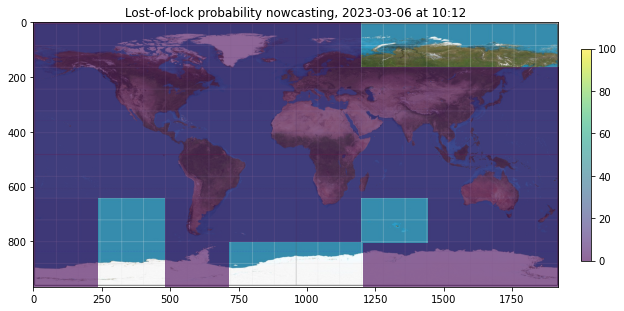

In [86]:
display_last_data(1,0)